<a href="https://colab.research.google.com/github/BeccaOY/BeccaOY/blob/main/Customer_Subscription_Status_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BUSINESS OBJECTIVE:
- Train a model to predict customers who will unsubscribe in July 2018



BUSINESS HYPOTHESES: 
Customers who unsubcribe are likely...
- Received too many emails
- Acquired recently
- Not as engaged 
	- less store visit
	- less email open & click
	- spend less
	- shop in fewer product areas
	- no dillards' credit card
- Live further from store


LOAD IN DATA WITH PANDAS

In [145]:
import pandas as pd
import numpy as np

sub_status = pd.read_csv('customer_subscription_status.csv')
email_activity = pd.read_csv('customer_email_campaign_agg.txt')
customer_info = pd.read_csv('customer.txt')
store_location= pd.read_csv('store_location.txt')
purchase_info = pd.read_csv('transaction_detail.txt')
items = pd.read_csv('item.txt')

In [146]:
#perform feature engineering by recoding y, n to 0,1
def recode(series):
    if series == 'N':
      return 1
    if series == 'Y':
      return 0
sub_status['unsubscribed_yn'] = sub_status['unsubscribed_yn'].apply(recode)

In [147]:
#perform feature engineering by recoding y, n to 0,1
def recode(series):
    if series == 'N':
      return 0
    if series == 'Y':
      return 1
customer_info['household_has_dillards_credit_card'] = customer_info['household_has_dillards_credit_card'].apply(recode)

BREAK DOWN DIFFERENT DATASETS TO INCLUDE ONLY RELEVANT COLUMNS

In [148]:
from numpy.core.fromnumeric import product
Target = sub_status['unsubscribed_yn']
email_engagement = email_activity[['total_email_sent_count', 'total_email_click_count', 'total_email_open_count']]
customer_details = customer_info[['customer_contact_acquisition_date', 'household_has_dillards_credit_card','household_distance_to_nearest_store']]
transactions = purchase_info[['netSpend','customer_id','item_id']]
products = items[['item_id','product_category']]


In [149]:
Target.tail(50)

24950    0
24951    0
24952    0
24953    0
24954    0
24955    0
24956    0
24957    0
24958    0
24959    0
24960    0
24961    0
24962    0
24963    0
24964    0
24965    0
24966    0
24967    0
24968    0
24969    0
24970    0
24971    0
24972    0
24973    0
24974    0
24975    0
24976    0
24977    0
24978    0
24979    0
24980    0
24981    0
24982    0
24983    0
24984    0
24985    0
24986    0
24987    0
24988    0
24989    0
24990    0
24991    0
24992    0
24993    0
24994    0
24995    0
24996    0
24997    0
24998    0
24999    0
Name: unsubscribed_yn, dtype: int64

In [150]:
purchases = pd.merge(transactions,products, on = 'item_id')
customer_by_product_areas = pd.DataFrame(purchases.groupby('customer_id')['product_category'].count())
customer_by_product_areas

,product_category
customer_id,
115614798,18
115626104,25
115626867,5
115627422,5
115627578,1
...,...
226645567,1
226646215,1
226647569,2


In [151]:
#get number of visits

from pandas.core.algorithms import value_counts
visit_frequency = pd.DataFrame(purchase_info.customer_id.value_counts())
visit_frequency


,customer_id
168362845,628
218917163,516
216353708,489
223779446,420
221036205,409
...,...
224404887,1
119319942,1
223382914,1
225587052,1


In [152]:
#get average spend amount
average_spend = pd.DataFrame(transactions.groupby('customer_id')['netSpend'].mean())

In [153]:
#Remove unknown values
customer_details_new = customer_details.replace("?", np.nan)
customer_details_new.count()
customer_details_new

,customer_contact_acquisition_date,household_has_dillards_credit_card,household_distance_to_nearest_store
0,11/3/2017,0,NaN
1,2/17/2018,1,NaN
2,5/15/2018,0,NaN
3,12/23/2017,0,NaN
4,9/19/2013,0,4.708
...,...,...,...
24995,7/27/2018,0,27.048
24996,12/3/2017,0,NaN
24997,9/10/2016,0,5.913
24998,2/5/2009,1,11.486


CREATE ONE DATAFRAME WITH ALL FEATURES AND LABEL

In [154]:
#add all datasets as a list
datasets = [email_engagement,visit_frequency,average_spend,customer_by_product_areas,customer_details_new,Target]

In [155]:
#merge datasets
dataset_1 = pd.concat(datasets, join='outer', axis=1).fillna(0)
dataset_1

,total_email_sent_count,total_email_click_count,total_email_open_count,customer_id,netSpend,product_category,customer_contact_acquisition_date,household_has_dillards_credit_card,household_distance_to_nearest_store,unsubscribed_yn
0,55.0,0.0,16.0,0.0,0.00,0.0,11/3/2017,0.0,0,1.0
1,29.0,1.0,3.0,0.0,0.00,0.0,2/17/2018,1.0,0,1.0
2,24.0,0.0,0.0,0.0,0.00,0.0,5/15/2018,0.0,0,1.0
3,22.0,0.0,0.0,0.0,0.00,0.0,12/23/2017,0.0,0,1.0
4,2.0,0.0,1.0,0.0,0.00,0.0,9/19/2013,0.0,4.708,1.0
...,...,...,...,...,...,...,...,...,...,...
226645567,0.0,0.0,0.0,1.0,16.00,1.0,0,0.0,0,0.0
226646215,0.0,0.0,0.0,1.0,130.00,1.0,0,0.0,0,0.0
226647569,0.0,0.0,0.0,2.0,46.44,2.0,0,0.0,0,0.0
226653022,0.0,0.0,0.0,1.0,27.99,1.0,0,0.0,0,0.0


SPLIT DATA

In [156]:
x = dataset_1[['total_email_sent_count', 'total_email_click_count', 'total_email_open_count', 'netSpend', 'product_category', 'household_has_dillards_credit_card','household_distance_to_nearest_store']]
y = dataset_1['unsubscribed_yn']

In [157]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .33)

In [158]:
from sklearn.linear_model import LogisticRegression
#set regularization to generaliza and avoid overfitting
reg = .01
model = LogisticRegression(C=1/reg,solver='liblinear').fit(x_train,y_train)
print(model)

LogisticRegression(C=100.0, solver='liblinear')


EVALUATE MODEL

In [159]:
prediction = model.predict(x_test)
prediction

array([0., 0., 1., ..., 1., 0., 1.])

CHECK ACCURACY

In [160]:
from sklearn.metrics import accuracy_score
accuracy_score = accuracy_score(y_test, prediction)
print('Accuracy Score: ', accuracy_score)

Accuracy Score:  0.9513617387847061


MODEL IS 90% ACCURATE AT PREDICTING SUBSCRIPTION STATUS



Provide classification report

In [161]:
from sklearn. metrics import classification_report

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95      8506
         1.0       0.90      1.00      0.95      6585

    accuracy                           0.95     15091
   macro avg       0.95      0.96      0.95     15091
weighted avg       0.96      0.95      0.95     15091



In [162]:
from sklearn.metrics import precision_score, recall_score

print("Overall Precision:",precision_score(y_test, prediction))
print("Overall Recall:",recall_score(y_test, prediction))

Overall Precision: 0.9008083299082066
Overall Recall: 0.9984813971146546


In [163]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
cm = confusion_matrix(y_test, prediction)
print (cm)

[[7782  724]
 [  10 6575]]


In [164]:
y_scores = model.predict_proba(x_test)
print(y_scores)

[[1.00000000e+00 1.65180984e-10]
 [9.99999999e-01 1.04597099e-09]
 [4.32689190e-01 5.67310810e-01]
 ...
 [1.87668057e-01 8.12331943e-01]
 [5.03779027e-01 4.96220973e-01]
 [4.11829047e-01 5.88170953e-01]]


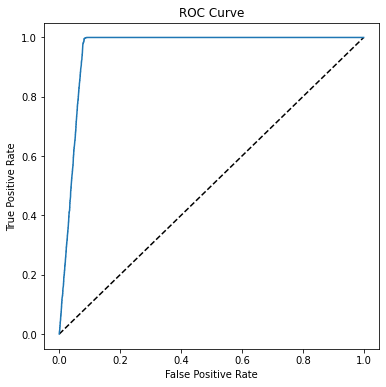

In [165]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [166]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ', auc)

AUC:  0.960489607496678


# SAVE MODEL FOR FUTURE USE

In [167]:
import joblib

# Save the model as a pickle file
filename = './unsubscribe_model.pkl'
joblib.dump(model, filename)

['./unsubscribe_model.pkl']